**Table of Contents:**

>[About task:](#scrollTo=YIrFQDXQrVwO)

>[Required libraries](#scrollTo=Zez0kj_Wc42W)

>[Penguin Dataset](#scrollTo=n-wT--WPdB2V)

>[Feature Engineering](#scrollTo=pYmPGc_7dJqQ)

>[Variational Classifier](#scrollTo=2ee90Ctld2Kf)

>>[Choosing feature](#scrollTo=2rDWp-f_eC6p)

>[References:](#scrollTo=sbpVYFcMnZHy)



# About task:
This notebook is an adaptation of the referenced notebook. My contributions include:

- **Dataset selection:** Worked on a different dataset, [Penguin Dataset: The New Iris](https://www.kaggle.com/code/parulpandey/penguin-dataset-the-new-iris) from Kaggle. I previously worked with this dataset using classical machine learning techniques. You can find my earlier work [here](https://www.kaggle.com/code/asadullahgalib/penguin-species-classification-with-kfold-cv).
- **Feature engineering:** Performed some feature engineering steps, eg. exploratory data analysis(EDA), handling nan values, normalization, etc.
- **Problem simplification:** While the original dataset presents a multiclass challenge with three species (Adelie, Gentoo, and Chinstrap), I focused on a binary classification problem by selecting only Gentoo and Chinstrap species.

# Required libraries

In [ ]:
# !pip install pennylane -q

In [ ]:
# qml packages
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

# others req.
import matplotlib.pyplot as plt
import pandas as pd
# import numpy as np
import seaborn as sns

# Penguin Dataset

In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('key')
os.environ["KAGGLE_USERNAME"] = userdata.get('username')

In [ ]:
# # Downloading data from Kaggle
# !kaggle datasets download -d parulpandey/palmer-archipelago-antarctica-penguin-data
# !unzip -q "/content/palmer-archipelago-antarctica-penguin-data.zip"

In [ ]:
data = pd.read_csv("/content/penguins_size.csv")

In [ ]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   culmen_length_mm   342 non-null    float64
 3   culmen_depth_mm    342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                334 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB


In [ ]:
data.species.value_counts()

,count
species,
Adelie,152
Gentoo,124
Chinstrap,68


In [ ]:
def bar_chart(feature):
    Adelie = data[data['species'] == 'Adelie'][feature].value_counts()
    Gentoo = data[data['species'] == 'Gentoo'][feature].value_counts()
    Chinstrap = data[data['species'] == 'Chinstrap'][feature].value_counts()

    df = pd.DataFrame([Adelie, Gentoo, Chinstrap])
    df.index = ['Adelie', 'Gentoo', 'Chinstrap']
    df.plot(kind = 'bar', stacked = True, figsize = (5,5))

In [ ]:
# No of null values in each feature
data.isnull().sum()

,0
species,0
island,0
culmen_length_mm,2
culmen_depth_mm,2
flipper_length_mm,2
body_mass_g,2
sex,10


# Feature Engineering

In [ ]:
# filling culmen length nan values with median value
data['culmen_length_mm'].fillna(data.groupby('island')['culmen_length_mm'].transform('median'), inplace = True)

In [ ]:
# filling culmen depth nan values with median value
data['culmen_depth_mm'].fillna(data.groupby('island')['culmen_depth_mm'].transform('median'), inplace = True)

In [ ]:
# filling flipper length nan values with median value
data['flipper_length_mm'].fillna(data.groupby('island')['flipper_length_mm'].transform('median'), inplace = True)

In [ ]:
# filling body mass nan values with median value
data['body_mass_g'].fillna(data.groupby('island')['body_mass_g'].transform('median'), inplace = True)

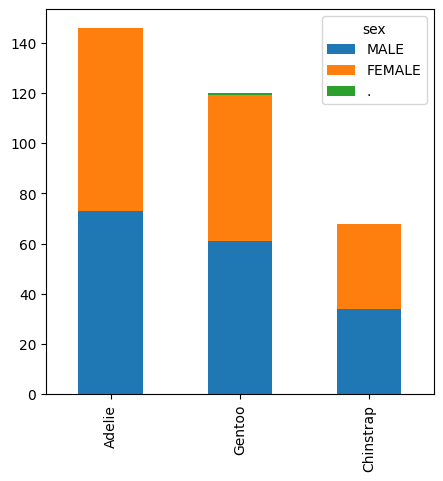

In [ ]:
# Plotting gender data
bar_chart('sex')

In [ ]:
# gender has no role in identifying species. So, let's drop it.
data = data.drop('sex', axis = 1)

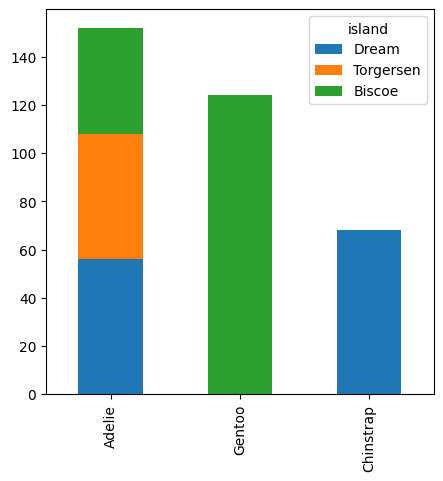

In [ ]:
bar_chart('island')

Observation:
- Gentoo is only from Biscoe island.
- Chinstrap is only from Dream island.
- Adelie is from all 3 islands(Dream, Torgersen, Biscoe).

In [ ]:
# Dropping the Adelie class to make the challenge binary classification
data = data[~data.species.str.contains("Adelie")]

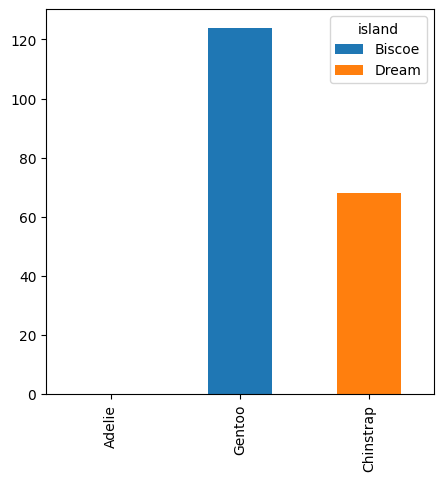

In [ ]:
bar_chart('island')

In [ ]:
# resetting the index
data = data.reset_index(drop=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            192 non-null    object 
 1   island             192 non-null    object 
 2   culmen_length_mm   192 non-null    float64
 3   culmen_depth_mm    192 non-null    float64
 4   flipper_length_mm  192 non-null    float64
 5   body_mass_g        192 non-null    float64
dtypes: float64(4), object(2)
memory usage: 9.1+ KB


In [ ]:
# Encoding data -> Gentoo: 1, Chinstrap: -1

dataset = [data]

island_mapping = {"Biscoe": 0, "Dream": 1, "Torgersen": 2}
# species_mapping = {"Adelie": 0, "Gentoo": 1, "Chinstrap": 2}
species_mapping = {"Gentoo": 1, "Chinstrap": -1}

for item in dataset:
    item['island'] = item['island'].map(island_mapping)
    item['species'] = item['species'].map(species_mapping)

In [ ]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,-1,1,46.5,17.9,192.0,3500.0
1,-1,1,50.0,19.5,196.0,3900.0
2,-1,1,51.3,19.2,193.0,3650.0
3,-1,1,45.4,18.7,188.0,3525.0
4,-1,1,52.7,19.8,197.0,3725.0


In [ ]:
# normalizing the data between 0-1(Min-Max Scaling)
columns_to_normalize = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']
for column in columns_to_normalize:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())


In [ ]:
data.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g
0,-1,1,0.299465,0.623377,0.264151,0.222222
1,-1,1,0.486631,0.831169,0.339623,0.333333
2,-1,1,0.556150,0.792208,0.283019,0.263889
3,-1,1,0.240642,0.727273,0.188679,0.229167
4,-1,1,0.631016,0.870130,0.358491,0.284722


# Variational Classifier

In [ ]:
dev = qml.device("default.qubit")

In [ ]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])


def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

In [ ]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [ ]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

In [ ]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

In [ ]:
def get_angles(x):
    # customized angle embedding
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

    # qml.StronglyEntanglingLayers(weights = a, wires = range(4))

## Choosing feature

In [ ]:
X = data.drop(['species', 'island', 'culmen_length_mm', 'flipper_length_mm'], axis = 1).to_numpy()
Y = data['species'].to_numpy()

In [ ]:
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

First X sample (original)  : [0.62337662 0.22222222]
First X sample (padded)    : [0.62337662 0.22222222 0.1        0.1       ]
First X sample (normalized): [0.92114229 0.32837017 0.14776658 0.14776658]
First features sample      : [ 0.42105032 -0.78539816  0.78539816 -0.34243726  0.34243726]


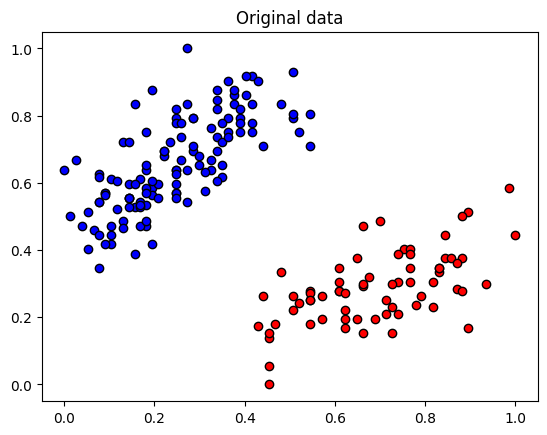

In [ ]:
plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

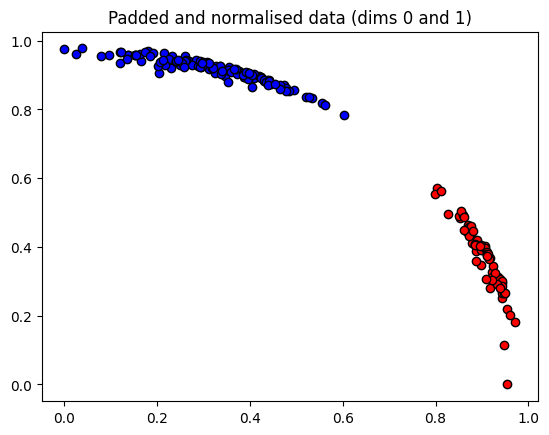

In [ ]:
plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

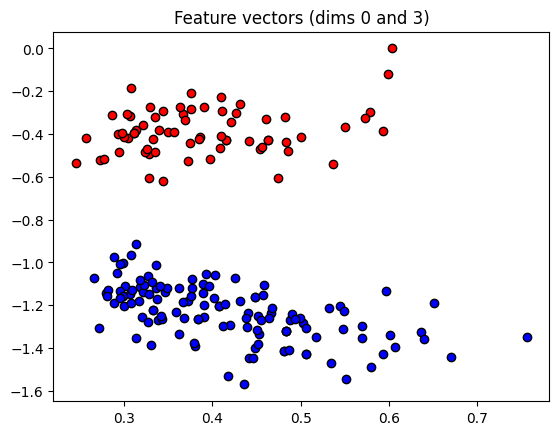

In [ ]:
plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

In [ ]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

In [ ]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [ ]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(100):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.1882543 | Acc train: 0.6388889 | Acc validation: 0.6666667
Iter:     4 | Cost: 1.0678453 | Acc train: 0.6388889 | Acc validation: 0.6666667
Iter:     6 | Cost: 0.9589011 | Acc train: 0.6388889 | Acc validation: 0.6666667
Iter:     8 | Cost: 0.9321252 | Acc train: 0.6319444 | Acc validation: 0.6666667
Iter:    10 | Cost: 0.9567222 | Acc train: 0.6597222 | Acc validation: 0.6041667
Iter:    12 | Cost: 0.9494938 | Acc train: 0.6458333 | Acc validation: 0.6041667
Iter:    14 | Cost: 0.9180374 | Acc train: 0.6944444 | Acc validation: 0.6875000
Iter:    16 | Cost: 0.8810750 | Acc train: 0.7222222 | Acc validation: 0.7083333
Iter:    18 | Cost: 0.8405985 | Acc train: 0.6597222 | Acc validation: 0.6666667
Iter:    20 | Cost: 0.8142704 | Acc train: 0.6458333 | Acc validation: 0.6666667
Iter:    22 | Cost: 0.8033483 | Acc train: 0.6388889 | Acc validation: 0.6666667
Iter:    24 | Cost: 0.7406625 | Acc train: 0.6666667 | Acc validation: 0.6875000
Iter:    26 | Cost: 0.666814

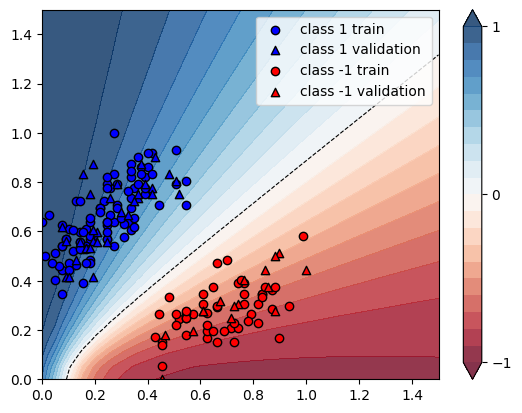

In [ ]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()

**What could be done more:**
- **One to One Classification:** This approach would allow for a more comprehensive analysis of the distinguishing features between the other penguin specie.
- **Ansatz(e):** Choosing different embedding and ansatze to solve the problem and comparing the approaches.

# References:

---
- [PennyLane Demo: Variational Classifier](https://pennylane.ai/qml/demos/tutorial_variational_classifier/) by Maria Schuld.

**By -**

Name: Asadullah Bin Rahman

Email: [galib.cse.17020221@std.hstu.ac.bd](galib.cse.17020221@std.hstu.ac.bd)

[Portfolio](https://asadullahgalib007.github.io/), [LinkedIn](https://www.linkedin.com/in/asadullah-bin-rahman/), [Google Scholar](https://scholar.google.com/citations?user=mhuUG2oAAAAJ&hl=en)